## Import libraries:

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Importing the datasets:

In [159]:
data1 = pd.read_csv('./train.csv')

## Data Exploration:

#### Data Dictionary:
* **survival:** Survival 	0 = No, 1 = Yes
* **pclass:** 	Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
* **sex:** 	Sex 	
* **Age:** 	Age in years 	
* **sibsp:** 	# of siblings / spouses aboard the Titanic 	
* **parch:** 	# of parents / children aboard the Titanic 	
* **ticket:** 	Ticket number 	
* **fare:** 	Passenger fare 	
* **cabin:** 	Cabin number 	
* **embarked:** 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

#### Variable Notes:
**pclass**: A proxy for socio-economic status (SES)
**1st** = Upper
**2nd** = Middle
**3rd** = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
**Sibling** = brother, sister, stepbrother, stepsister
**Spouse** = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
**Parent** = mother, father
**Child** = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [143]:
data1.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [116]:
#Checking the datatype of the columns

for i in data1.columns:
    print(i," ",data1[i].dtype)

PassengerId   int64
Survived   int64
Pclass   int64
Name   object
Sex   object
Age   float64
SibSp   int64
Parch   int64
Ticket   object
Fare   float64
Cabin   object
Embarked   object


In [144]:
data1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [160]:
#'Cabin' and 'Ticket' columns doesn't hold any relevant information for us. We are dropping them.

data2=data1.drop(['Cabin','Ticket'], axis=1)

In [192]:
#Checking how many null values are there for each column

data2.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

We have missing values for 'Age' and 'Embarked'. We need to take care of these missing values.

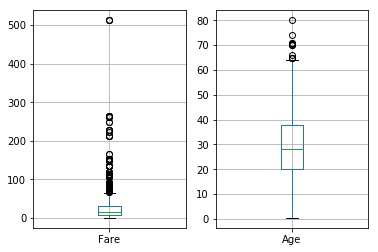

In [147]:
plt.subplot(1,2,1)
data2.boxplot(column='Fare')

plt.subplot(1,2,2)
data2.boxplot(column='Age')

From the above box-plot we can see that 'Age' values are within limit(less than 90), but certain 'Fare' values are extremely high.

## Removing outliers for 'Fare':

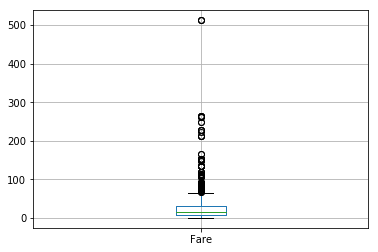

In [162]:
#Checking outliers for 'Fare' with box plot.

data2.boxplot(column='Fare', figsize=(8, 8))

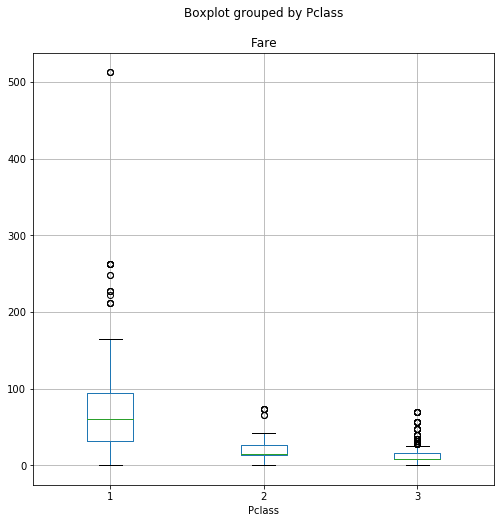

In [163]:
#Checking outliers for 'Fare' for different 'Pclass'.

data2.boxplot(column='Fare', by='Pclass', figsize=(8,8))

In [164]:
#Finding out the entries with 'Fare'>300

data2[data2['Fare']>300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,512.3292,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,512.3292,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,512.3292,C


From above plots and records, it seems there are 3 values for 'Fare' which are extremely high and likely to be data error. We will remove these 3 outliers with the 2nd highest value of 'Fare'.

In [165]:
#data2.sort_values(by='Fare', ascending=False)

#Replacing the values higher than 500 with the second highest fare in the dataframe
data2.Fare[data2['Fare']>500]=263.0000

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


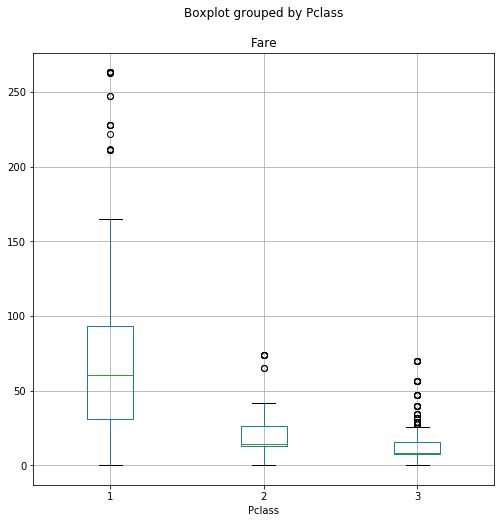

In [166]:
data2.boxplot(column='Fare', by='Pclass', figsize=(8,8))

In the above box plot, even though there are a few outliers, they can be ignored as passengers may pay more than the normal ticket price to obtain extra amenities for their voyage with RMS Titanic. After all Titanic was one of the luxurious voyages of it's time.

## Impute missing values for age:
In data exploration, we found that there are 177 missing values for ages. We are going to impute these missing values with the following method:
* Extract the salutaions from 'Name' column.
* Group the salutations into 5 different categories under column 'New_Salutation'.
* Create a pivot table with median 'Age' values for 'Sex', 'Pclass' and 'New_Salutation' columns.
* Fill the missing 'Age' values from the pivot table.

In [193]:
#Extracting salutation from 'Name' column

def name_extract(x):
    return x.split(', ')[1].split('.')[0]

df2=pd.DataFrame({'Salutation':data2['Name'].apply(name_extract)})
df2.tail()

,Salutation
886,Rev
887,Miss
888,Miss
889,Mr
890,Mr


In [194]:
#Creating a new dataset 'data3' by merging the old dataset('data2') with column 'Salutation'
data3 = pd.merge(data2, df2, left_index=True, right_index=True)

#Doing a group_by on 'Salutations' and finding the count of each salutation.
data3[['Salutation','PassengerId']].groupby('Salutation').count()

,PassengerId
Salutation,
Capt,1
Col,2
Don,1
Dr,7
Jonkheer,1
Lady,1
Major,2
Master,40
Miss,182


In [195]:
#Grouping salutations: creating column 'New_Salutation' containing 5 final groups(Mr, Master, Miss, Mrs, Special)
#'Special' salutations will contain 'Capt', 'Col', 'Don', 'Dr', 'Major' etc

def group_salutation(old_salutation):
    if old_salutation=='Mr':
        return('Mr')
    elif old_salutation=='Master':
        return('Master')
    elif old_salutation=='Miss' or old_salutation=='Ms' or old_salutation=='Mlle' or old_salutation=='Lady' or old_salutation=='Mme':
        return('Miss')
    elif old_salutation=='Mrs':
        return('Mrs')
    else:
        return('Special')

#.apply() returns a value after passing each row/column of a data frame to default/user-defined function. 
df3 = pd.DataFrame({'New_Salutation':data3['Salutation'].apply(group_salutation)})

#Creating a new dataset by merging the old dataset with the new dataset containing 'New_Salutation'
data4 = pd.merge(data3, df3, left_index=True, right_index=True)
data4[['New_Salutation','PassengerId']].groupby('New_Salutation').count()

,PassengerId
New_Salutation,
Master,40
Miss,187
Mr,517
Mrs,125
Special,22


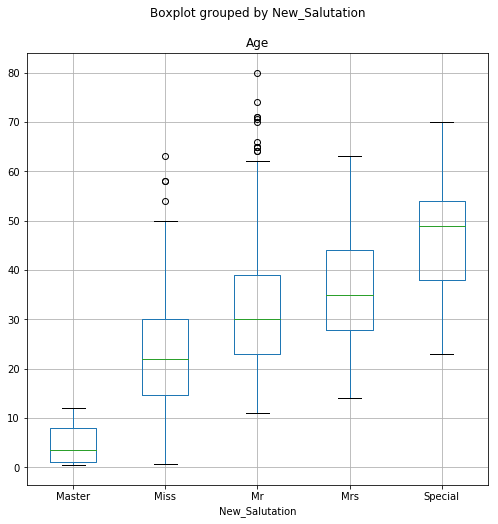

In [196]:
data4.boxplot(column='Age', by='New_Salutation', figsize=(8,8))

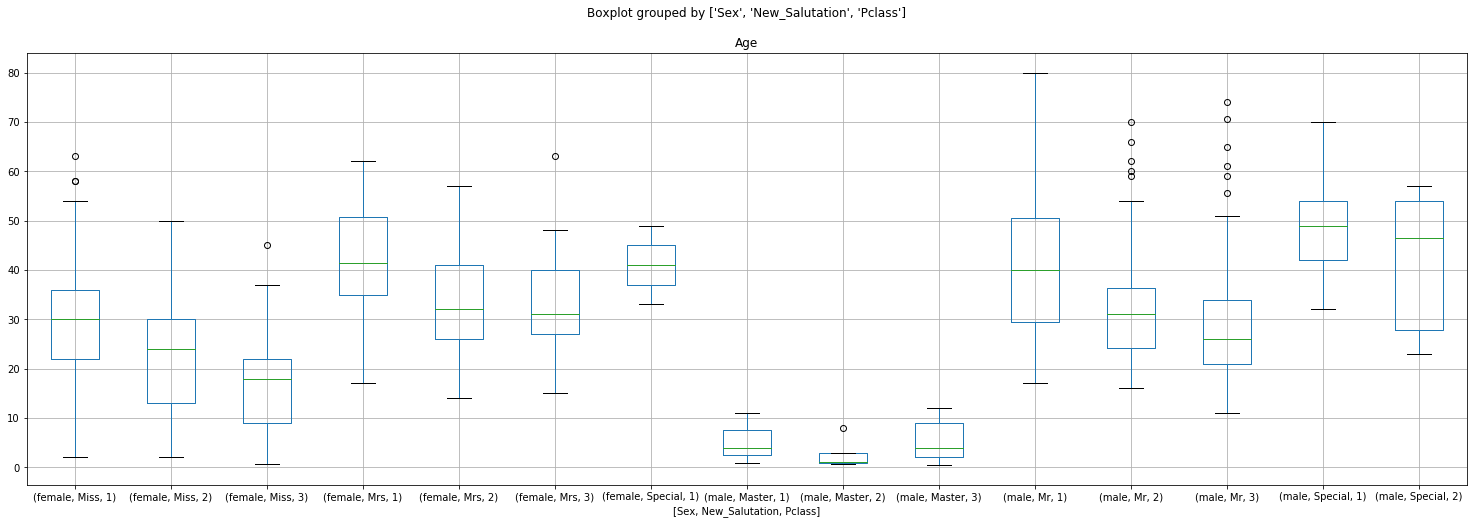

In [197]:
data4.boxplot(column='Age', by=['Sex','New_Salutation','Pclass'], figsize=(25,8))

In [202]:
#We create a Pivot table, which provides us the median values for the columns mentioned below:

pv_table = data4.pivot_table(values='Age', index='New_Salutation', columns=['Sex', 'Pclass'], aggfunc=np.median)
pv_table

Sex            female              male            
Pclass              1     2     3     1     2     3
New_Salutation                                     
Master            NaN   NaN   NaN   4.0   1.0   4.0
Miss             30.0  24.0  18.0   NaN   NaN   NaN
Mr                NaN   NaN   NaN  40.0  31.0  26.0
Mrs              41.5  32.0  31.0   NaN   NaN   NaN
Special          41.0   NaN   NaN  49.0  46.5   NaN

In [ ]:
#We define a function, which returns the values from the pivot table 'pv_table'.
def get_age(x):
    return pv_table[x['Sex']][x['Pclass']][x['New_Salutation']]
    return pv_table[x['Sex']][x['Pclass']][x['New_Salutation']]

#Apply the above created function to fill the missing values of age:
data4['Age'] = data4['Age'].fillna(data4[data4['Age'].isnull()].apply(get_age, axis=1))

In [199]:
#Check if missing values of 'Age' have been filled.
data4.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Embarked          2
Salutation        0
New_Salutation    0
dtype: int64

## Impute the missing values for 'Embarked':
Fill the missing values in 'Embarked' column with the mode function.

In [203]:
data4.groupby('Embarked').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Salutation,New_Salutation
Embarked,,,,,,,,,,,
C,168,168,168,168,168,168,168,168,168,168,168
Q,77,77,77,77,77,77,77,77,77,77,77
S,644,644,644,644,644,644,644,644,644,644,644


In [204]:
#mode returns a series. So you need to access the row you want, before replacing NaN values in your DataFrame.
#So df['column'].mode()[0] needs to be used here.

data4['Embarked'].fillna(data4['Embarked'].mode()[0], inplace=True)

In [206]:
data4.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Embarked          0
Salutation        0
New_Salutation    0
dtype: int64

## Checking how 'Pclass', 'Sex', 'Age' and 'Fare' impacts the survival rate of the passengers

#### Imapct of 'Pclass' on survival of passenger
* We are using crosstab to check if 'Pclass' has impact on survival of the passengers.
* From the pivot table and bar plot, it seems class-1 passenger has higher chance of survival than class-3 passengers.

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119


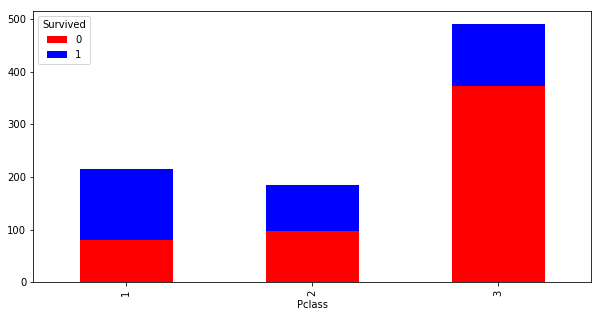

In [238]:
temp1=pd.crosstab(data4['Pclass'],data4['Survived'])
print(temp1)
temp1.plot(kind='bar', stacked=True, color=['red','blue'], grid=False, figsize=(10,5))

#### Imapct of 'Sex' on survival of passenger
* We are using crosstab to check if 'Sex' has impact on survival of the passengers.
* From the pivot table and bar plot, it seems female passenger has higher chance of survival than male passengers.

Survived    0    1
Sex               
female     81  233
male      468  109


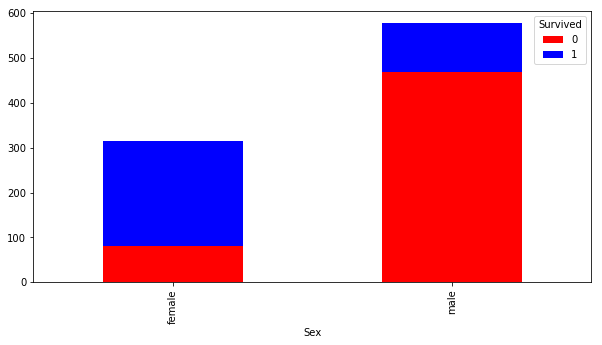

In [240]:
temp2=pd.crosstab(data4['Sex'],data4['Survived'])
print(temp2)
temp2.plot(kind='bar', stacked=True, color=['red','blue'], grid=False, figsize=(10,5))

#### Imapct of 'Age' on survival of passenger
* We have converted the continous variable 'Age' to a categorical variable 'age_bins' using cut() function.
* Then, we are using crosstab to check if age has impact on survival of the passengers.
* From the pivot table and bar plot, it seems children have higher chance of survival compared to adults and aged.

In [247]:
#Here, we are binning the 'Age' variable to create a categorical variable with 3 values.
#first parameter of cut() function is a series here containing the 'Age'
#Second parameter contains the range in which 'Age' is to be binned.
#Third parameter contains the labels to be used on the resulting bins.

data4['age_bins']=pd.cut(data4['Age'], [0,15,50,100],labels=['child','adult','aged'])
data4['age_bins'].value_counts()

adult    740
child     87
aged      64
Name: age_bins, dtype: int64

Survived    0    1
age_bins          
adult     471  269
aged       42   22
child      36   51


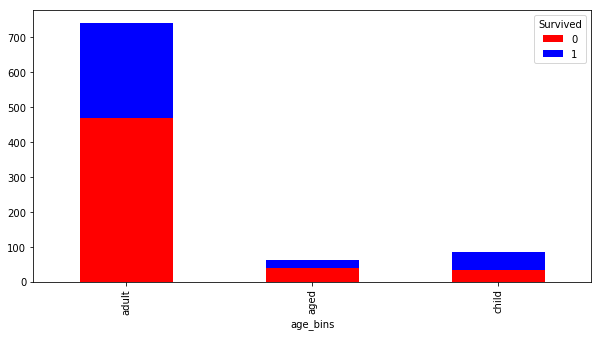

In [248]:
temp3=pd.crosstab(data4['age_bins'],data4['Survived'])
print(temp3)
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False, figsize=(10,5))

Survived                  0   1
Pclass Sex    age_bins         
1      female adult       2  76
              aged        0  13
              child       1   2
       male   adult      56  37
              aged       21   5
              child       0   3
2      female adult       5  58
              aged        1   2
              child       0  10
       male   adult      80   7
              aged       11   1
              child       0   9
3      female adult      58  55
              aged        0   1
              child      14  16
       male   adult     270  36
              aged        9   0
              child      21  11


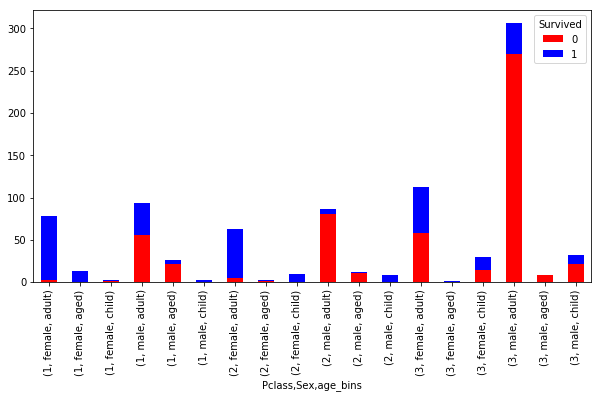

In [258]:
temp4=pd.crosstab([data4['Pclass'],data4['Sex'],data4['age_bins']],data4['Survived'])
print(temp4)
temp4.plot(kind='bar', stacked=True, color=['red','blue'], grid=False, figsize=(10,5))

from the above plots, it seems that female passengers have pretty higher chances of survival. So `sex` can be considered as the strongest survival factor here. The `passenger class` also plays a major role here. The survival scale tips towards the first class passenger compared to second class passengers and third class passengers having the highest mortality rate. After classifying the passengers to 'child', 'adult' and 'aged', it becomes clear that children and aged people have higher chance of coming out alive than the adults.

## Applying ML:

In [417]:
data4.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Salutation', 'New_Salutation',
       'age_bins'],
      dtype='object')

Binarizing 'Sex' column to 0 and 1 with 0 being female and 1 being male.

In [319]:
final_data = data4.copy()
final_data['Sex'] = (final_data['Sex'] == 'male')*1
print(final_data['Sex'].head(10))

0    1
1    0
2    0
3    0
4    1
5    1
6    1
7    1
8    0
9    0
Name: Sex, dtype: int32


Store the target in 'y' and the input features in 'X'

In [423]:
X=final_data[['Pclass','Sex','Age','SibSp','Parch']].copy()
y=final_data[['Survived']].copy()

#X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=324)

Train the model using DecisionTreeClassifier.

In [424]:
model_survival = DecisionTreeClassifier(max_leaf_nodes=12, random_state=0)
model_survival.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=12, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [426]:
model_survival.score(X, y)

0.84624017957351294

In [317]:
#predictions = model_survival.predict(X_test)
#accuracy_score(y_true = y_test, y_pred = predictions)

# Using the test data:
Here onwards we will be working with the test data to predict the survival of the passengers.

## Test Data Exploration:

In [329]:
test_data=pd.read_csv('./test.csv')

In [334]:
test_data.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [331]:
test_data2=test_data.drop(['Cabin','Ticket'], axis=1)

In [335]:
test_data2.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

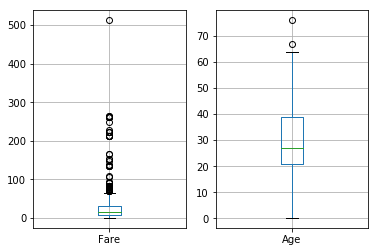

In [336]:
plt.subplot(1,2,1)
test_data2.boxplot(column='Fare')

plt.subplot(1,2,2)
test_data2.boxplot(column='Age')

In the test data 'Age' values are within limit(less than 90), but certain 'Fare' values are extremely high.

## Removing outliers for 'Fare' for test data:

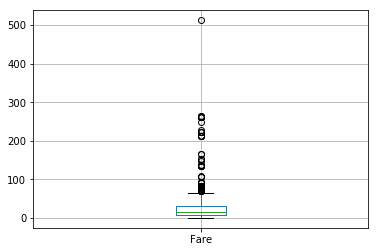

In [337]:
#Checking outliers for 'Fare' with box plot.

test_data2.boxplot(column='Fare', figsize=(8, 8))

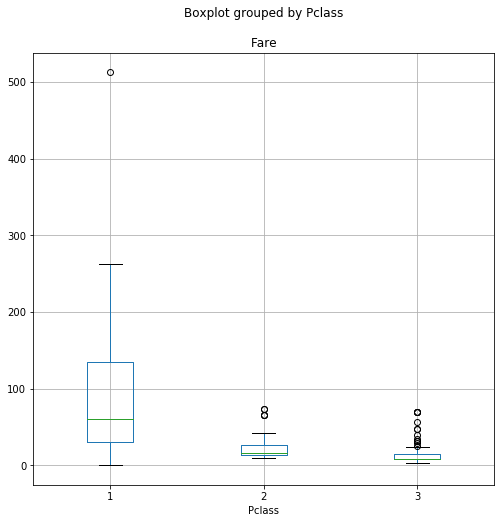

In [338]:
#Checking outliers for 'Fare' for different 'Pclass'.

test_data2.boxplot(column='Fare', by='Pclass', figsize=(8,8))

In [340]:
#Finding out the entries with 'Fare'>300

test_data2[test_data2['Fare']>300]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
343,1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,512.3292,C


From above plots and records, it seems there is one value for 'Fare' which is extremely high and likely to be data error. We will replace this outliers with the 2nd highest value of 'Fare'.

In [346]:
#test_data2.sort_values(by='Fare', ascending=False).head(3)

#Replacing the values higher than 500 with the second highest fare in the dataframe
test_data2.Fare[test_data2['Fare']>500]=263.0000

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


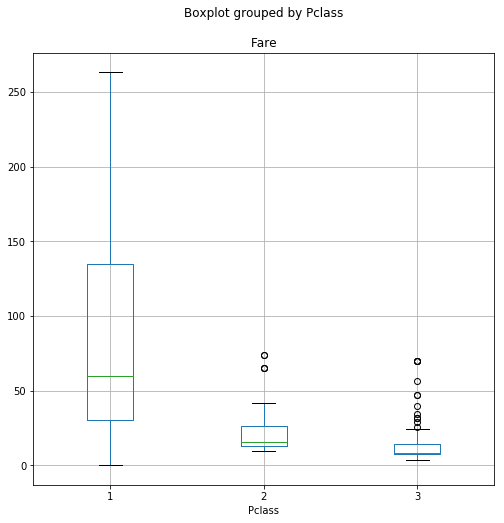

In [347]:
test_data2.boxplot(column='Fare', by='Pclass', figsize=(8,8))

In the above box plot, even though there are a few outliers, they can be ignored as passengers may pay more than the normal ticket price to obtain extra amenities for their voyage with RMS Titanic. After all Titanic was one of the luxurious voyages of it's time.

## Impute the missing value of 'Fare' for test data:
We are going to impute the missing value of 'Fare' by finding the mode() after grouping the values by 'Pclass'

In [348]:
test_data2[test_data2['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,S


Since the missing value of 'Fare' is for a passenger of Pclass=3, we will replace it with the mode() value of the same Pclass.

In [384]:
#To get the mode() value of 'Fare' where Pclass=3
test_data2['Fare'][test_data2['Pclass']==3].mode()

0    7.75
dtype: float64

In [386]:
#To do a groupby on 'Pclass' and get the mode() value of 'Fare'
test_data2.groupby('Pclass').agg(lambda x: x.value_counts().index[0])

,PassengerId,Name,Sex,Age,SibSp,Parch,Fare,Embarked
Pclass,,,,,,,,
1,1023,"Rothschild, Mr. Martin",male,55.0,0,0,26.55,C
2,1241,"Phillips, Miss. Alice Frances Louisa",male,30.0,0,0,13.00,S
3,1022,"Makinen, Mr. Kalle Edvard",male,21.0,0,0,7.75,S


In [391]:
#Replacing the missing value of 'Fare'
test_data2['Fare'].fillna(test_data2['Fare'][test_data2['Pclass']==3].mode()[0], inplace=True)

In [392]:
test_data2.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            0
Embarked        0
dtype: int64

## Impute missing values of age for test data:
In data exploration, we found that there are 86 missing values for ages. We are going to impute these missing values with the following method:
* Extract the salutaions from 'Name' column.
* Group the salutations into 5 different categories under column 'New_Salutation'.
* Create a pivot table with median 'Age' values for 'Sex', 'Pclass' and 'New_Salutation' columns.
* Fill the missing 'Age' values from the pivot table.

In [407]:
#Extracting salutation from 'Name' column

def name_extract(x):
    return x.split(', ')[1].split('.')[0]

df2=pd.DataFrame({'Salutation':test_data2['Name'].apply(name_extract)})
df2.tail()

,Salutation
413,Mr
414,Dona
415,Mr
416,Mr
417,Master


In [408]:
#Creating a new dataset 'data3' by merging the old dataset('data2') with column 'Salutation'
test_data3 = pd.merge(test_data2, df2, left_index=True, right_index=True)

#Doing a group_by on 'Salutations' and finding the count of each salutation.
test_data3[['Salutation','PassengerId']].groupby('Salutation').count()

,PassengerId
Salutation,
Col,2
Dona,1
Dr,1
Master,21
Miss,78
Mr,240
Mrs,72
Ms,1
Rev,2


In [409]:
#Grouping salutations: creating column 'New_Salutation' containing 5 final groups(Mr, Master, Miss, Mrs, Special)
#'Special' salutations will contain 'Capt', 'Col', 'Don', 'Dr', 'Major' etc

def group_salutation(old_salutation):
    if old_salutation=='Mr':
        return('Mr')
    elif old_salutation=='Master':
        return('Master')
    elif old_salutation=='Miss' or old_salutation=='Ms' or old_salutation=='Mlle' or old_salutation=='Lady' or old_salutation=='Mme':
        return('Miss')
    elif old_salutation=='Mrs':
        return('Mrs')
    else:
        return('Special')

#.apply() returns a value after passing each row/column of a data frame to default/user-defined function. 
df3 = pd.DataFrame({'New_Salutation':test_data3['Salutation'].apply(group_salutation)})

#Creating a new dataset by merging the old dataset with the new dataset containing 'New_Salutation'
test_data4 = pd.merge(test_data3, df3, left_index=True, right_index=True)
test_data4[['New_Salutation','PassengerId']].groupby('New_Salutation').count()

,PassengerId
New_Salutation,
Master,21
Miss,79
Mr,240
Mrs,72
Special,6


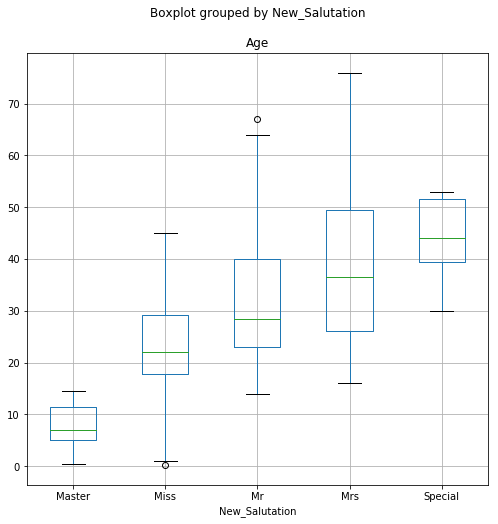

In [410]:
test_data4.boxplot(column='Age', by='New_Salutation', figsize=(8,8))

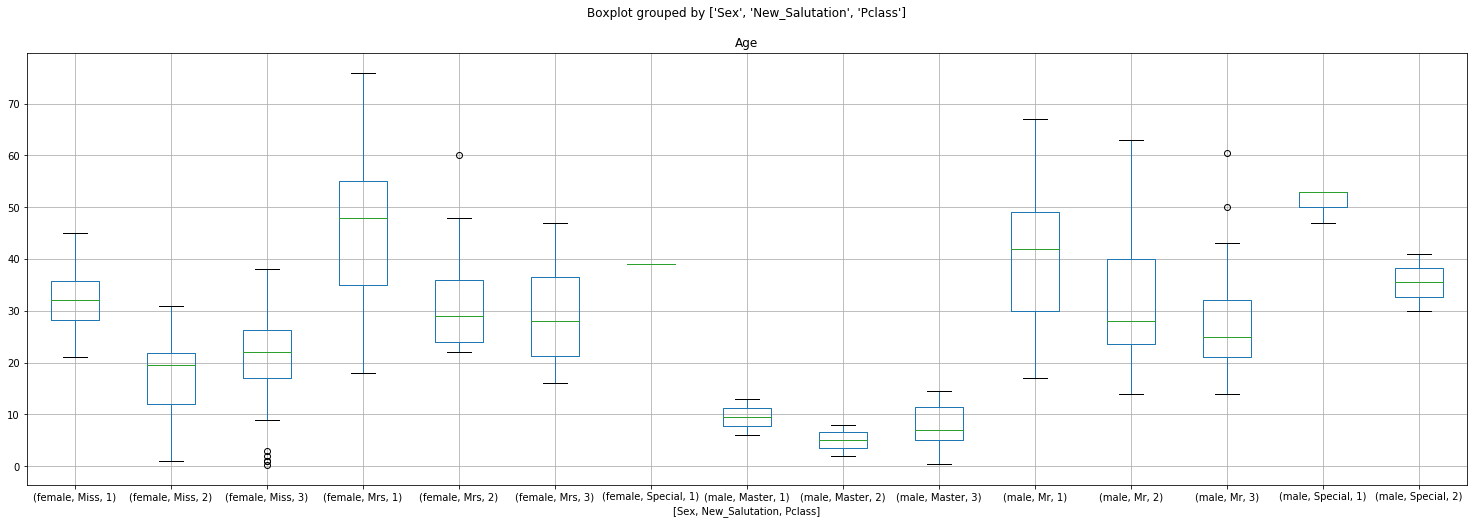

In [411]:
test_data4.boxplot(column='Age', by=['Sex','New_Salutation','Pclass'], figsize=(25,8))

In [412]:
#We create a Pivot table, which provides us the median values for the columns mentioned below:

pv_table = test_data4.pivot_table(values='Age', index='New_Salutation', columns=['Sex', 'Pclass'], aggfunc=np.median)
pv_table

Sex            female              male            
Pclass              1     2     3     1     2     3
New_Salutation                                     
Master            NaN   NaN   NaN   9.5   5.0   7.0
Miss             32.0  19.5  22.0   NaN   NaN   NaN
Mr                NaN   NaN   NaN  42.0  28.0  25.0
Mrs              48.0  29.0  28.0   NaN   NaN   NaN
Special          39.0   NaN   NaN  53.0  35.5   NaN

In [414]:
#We define a function, which returns the values from the pivot table 'pv_table'.
def get_age(x):
    return pv_table[x['Sex']][x['Pclass']][x['New_Salutation']]
    return pv_table[x['Sex']][x['Pclass']][x['New_Salutation']]

#Apply the above created function to fill the missing values of age:
test_data4['Age'] = test_data4['Age'].fillna(test_data4[test_data4['Age'].isnull()].apply(get_age, axis=1))

In [415]:
#Check if missing values of 'Age' have been filled.
test_data4.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Fare              0
Embarked          0
Salutation        0
New_Salutation    0
dtype: int64

## Applying ML:

In [416]:
test_data4.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Salutation', 'New_Salutation'],
      dtype='object')

Binarizing 'Sex' column to 0 and 1 with 0 being female and 1 being male.

In [427]:
final_test_data = test_data4.copy()
final_test_data['Sex'] = (final_test_data['Sex'] == 'male')*1
print(final_test_data['Sex'].head(10))

0    1
1    0
2    1
3    1
4    0
5    1
6    0
7    1
8    0
9    1
Name: Sex, dtype: int32


Store the target in 'y' and the input features in 'X'

In [430]:
X_test=final_test_data[['Pclass','Sex','Age','SibSp','Parch']].copy()

Train the model using DecisionTreeClassifier.

model_survival = DecisionTreeClassifier(max_leaf_nodes=12, random_state=0)
model_survival.fit(X, y)

In [431]:
predictions = model_survival.predict(X_test)
#accuracy_score(y_true = y_test, y_pred = predictions)

## To submit the prediction result to kaggle:
We will create a new dataframe that will contain the 'PassengerId' and 'Survived' column, where 'Survived' column will contain the predictions done by the ML model.

In [433]:
final_df=test_data4.copy()

In [436]:
final_df['Survived']=predictions

In [440]:
submit_df=final_df[['PassengerId','Survived']]
submit_df

In [443]:
submit_df.to_csv(path_or_buf='./my_submission.csv', index=False)